# Convert and play with the Singapore dataset

This is a jupyter notebook to experiment and generate the frames of the videos in the Singapore Maritime 
Dataset (SMD) as jpg images. Also, histograms of the objects heights, widths and areas as a ration of the total images are generated.

Dataset available here: https://sites.google.com/site/dilipprasad/home/singapore-maritime-dataset

If this dataset is used please cite it as:

D. K. Prasad, D. Rajan, L. Rachmawati, E. Rajabaly, and C. Quek, "Video Processing from Electro-optical Sensors for Object Detection and Tracking in Maritime Environment: A Survey," IEEE Transactions on Intelligent Transportation Systems (IEEE), 2017. 

In [1]:
import pkg_resources
from subprocess import call
for dist in pkg_resources.working_set:
    call(["pip", "install", "--upgrade", dist.project_name])

C:\Users\User\AppData\Local\Temp\ipykernel_10340\1541392777.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
from scipy.io import loadmat
from os import listdir
from os.path import isfile, join
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

Load the videos paths for both onboard and onshore data and generate dictionaries with it.

In [5]:
# Set the paths for the video files and ground truth files
# by default it is assumed that the paths are in the same folders
# as the notebook

VIDEOS_PATH_ONSHORE = "VIS_Onshore/Videos"
OBJECT_ANNOTATIONS_ONSHORE_PATH = "VIS_Onshore/ObjectGT"
VIDEO_FRAMES_PATH_ONSHORE = 'VIS_Onshore_frames/'

VIDEOS_PATH_ONBOARD = "VIS_Onboard/Videos"
OBJECT_ANNOTATIONS_ONBOARD_PATH = "VIS_Onboard/ObjectGT"
VIDEO_FRAMES_PATH_ONBOARD = 'VIS_Onboard_frames/'

VIDEOS_PATH_NIR = "NIR/Videos"
OBJECT_ANNOTATIONS_NIR_PATH = "NIR/ObjectGT"
VIDEO_FRAMES_PATH_NIR = 'NIR_frames/'

In [6]:
video_files_onshore = [join(VIDEOS_PATH_ONSHORE, f) for f in listdir(VIDEOS_PATH_ONSHORE) 
                       if isfile(join(VIDEOS_PATH_ONSHORE, f))]

video_files_onboard = [join(VIDEOS_PATH_ONBOARD, f) for f in listdir(VIDEOS_PATH_ONBOARD) 
                       if isfile(join(VIDEOS_PATH_ONBOARD, f))]

video_files_nir = [join(VIDEOS_PATH_NIR, f) for f in listdir(VIDEOS_PATH_NIR) 
                       if isfile(join(VIDEOS_PATH_NIR, f))]

Create dictionaries for each video in the form video_name:video_path

In [7]:
video_files_onshore_dict = {}
for f in listdir(VIDEOS_PATH_ONSHORE):
    if isfile(join(VIDEOS_PATH_ONSHORE, f)):
        video_files_onshore_dict[f.split('.')[0]] = join(VIDEOS_PATH_ONSHORE, f)
        
video_files_onboard_dict = {}
for f in listdir(VIDEOS_PATH_ONBOARD):
    if isfile(join(VIDEOS_PATH_ONBOARD, f)):
        video_files_onboard_dict[f.split('.')[0]] = join(VIDEOS_PATH_ONBOARD, f)
        
video_files_nir_dict = {}
for f in listdir(VIDEOS_PATH_NIR):
    if isfile(join(VIDEOS_PATH_NIR, f)):
        video_files_nir_dict[f.split('.')[0]] = join(VIDEOS_PATH_NIR, f)

Load the ground truth files paths for both onboard and onshore data and generate dictionaries with it.

In [8]:
object_gt_files_onshore_dict = {}
for f in listdir(OBJECT_ANNOTATIONS_ONSHORE_PATH):
    if isfile(join(OBJECT_ANNOTATIONS_ONSHORE_PATH, f)):
        object_gt_files_onshore_dict[f.split('.')[0].replace('_ObjectGT','')] = join(OBJECT_ANNOTATIONS_ONSHORE_PATH, f)
        
object_gt_files_onboard_dict = {}
for f in listdir(OBJECT_ANNOTATIONS_ONBOARD_PATH):
    if isfile(join(OBJECT_ANNOTATIONS_ONBOARD_PATH, f)):
        object_gt_files_onboard_dict[f.split('.')[0].replace('_ObjectGT','')] = join(OBJECT_ANNOTATIONS_ONBOARD_PATH, f)
        
object_gt_files_nir_dict = {}
for f in listdir(OBJECT_ANNOTATIONS_NIR_PATH):
    if isfile(join(OBJECT_ANNOTATIONS_NIR_PATH, f)):
        object_gt_files_nir_dict[f.split('.')[0].replace('_ObjectGT','')] = join(OBJECT_ANNOTATIONS_NIR_PATH, f)

Do some sanity checks to see if there are equal numbers of videos and ground truth files.

In [9]:
print('Number of onshore videos: ', len(video_files_onshore_dict))
print('Number of onshore ground truth files: ', len(object_gt_files_onshore_dict))

print('Number of onboard videos: ', len(video_files_onboard_dict))
print('Number of onboard ground truth files: ', len(object_gt_files_onboard_dict))

print('Number of near infra-red videos: ', len(video_files_nir_dict))
print('Number of near infra-red ground truth files: ', len(object_gt_files_nir_dict))

Number of onshore videos:  40
Number of onshore ground truth files:  36
Number of onboard videos:  11
Number of onboard ground truth files:  4
Number of near infra-red videos:  30
Number of near infra-red ground truth files:  23


So there are videos without ground truth files. These unlabelled data might be good for testing later. Let's find these videos.

In [10]:
# ground truth files are missing - find the corresponding videos
missing_files_onshore = []
for key in video_files_onshore_dict.keys():
    if key not in object_gt_files_onshore_dict:
        missing_files_onshore.append(key)
        
print("Unlabelled onshore videos: ", missing_files_onshore)

missing_files_onboard = []
for key in video_files_onboard_dict.keys():
    if key not in object_gt_files_onboard_dict:
        missing_files_onboard.append(key)
        
print("Unlabelled onbord videos: ", missing_files_onboard)

missing_files_nir = []
for key in video_files_nir_dict.keys():
    if key not in object_gt_files_nir_dict:
        missing_files_nir.append(key)
        
print("Unlabelled nir videos: ", missing_files_nir)


# set whether to remove or not the missing videos from the frames generation later
remove_missing_files = True
if remove_missing_files:
    for key in missing_files_onshore:
        del video_files_onshore_dict[key]
    for key in missing_files_onboard:
        del video_files_onboard_dict[key]
    for key in missing_files_nir:
        del video_files_nir_dict[key]
        
    print()
    print('Size of video dictionaries after removing the videos without ground truth:')
    print('Number of onshore videos: ', len(video_files_onshore_dict))
    print('Number of onshore ground truth files: ', len(object_gt_files_onshore_dict))

    print('Number of onboard videos: ', len(video_files_onboard_dict))
    print('Number of onboard ground truth files: ', len(object_gt_files_onboard_dict))

    print('Number of near infra-red videos: ', len(video_files_nir_dict))
    print('Number of near infra-red ground truth files: ', len(object_gt_files_nir_dict))

Unlabelled onshore videos:  ['MVI_1470_VIS', 'MVI_1471_VIS', 'MVI_1483_VIS', 'MVI_1485_VIS']
Unlabelled onbord videos:  ['MVI_0788_VIS_OB', 'MVI_0789_VIS_OB', 'MVI_0792_VIS_OB', 'MVI_0794_VIS_OB', 'MVI_0795_VIS_OB', 'MVI_0796_VIS_OB', 'MVI_0804_VIS_OB']
Unlabelled nir videos:  ['MVI_1474_NIR', 'MVI_1475_NIR', 'MVI_1478_NIR', 'MVI_1480_NIR', 'MVI_1481_NIR', 'MVI_1483_NIR', 'MVI_1484_NIR']

Size of video dictionaries after removing the videos without ground truth:
Number of onshore videos:  36
Number of onshore ground truth files:  36
Number of onboard videos:  4
Number of onboard ground truth files:  4
Number of near infra-red videos:  23
Number of near infra-red ground truth files:  23


In [11]:
print(video_files_onshore_dict)

{'MVI_1448_VIS_Haze': 'VIS_Onshore/Videos\\MVI_1448_VIS_Haze.avi', 'MVI_1451_VIS_Haze': 'VIS_Onshore/Videos\\MVI_1451_VIS_Haze.avi', 'MVI_1452_VIS_Haze': 'VIS_Onshore/Videos\\MVI_1452_VIS_Haze.avi', 'MVI_1469_VIS': 'VIS_Onshore/Videos\\MVI_1469_VIS.avi', 'MVI_1474_VIS': 'VIS_Onshore/Videos\\MVI_1474_VIS.avi', 'MVI_1478_VIS': 'VIS_Onshore/Videos\\MVI_1478_VIS.avi', 'MVI_1479_VIS': 'VIS_Onshore/Videos\\MVI_1479_VIS.avi', 'MVI_1481_VIS': 'VIS_Onshore/Videos\\MVI_1481_VIS.avi', 'MVI_1482_VIS': 'VIS_Onshore/Videos\\MVI_1482_VIS.avi', 'MVI_1484_VIS': 'VIS_Onshore/Videos\\MVI_1484_VIS.avi', 'MVI_1486_VIS': 'VIS_Onshore/Videos\\MVI_1486_VIS.avi', 'MVI_1578_VIS': 'VIS_Onshore/Videos\\MVI_1578_VIS.avi', 'MVI_1582_VIS': 'VIS_Onshore/Videos\\MVI_1582_VIS.avi', 'MVI_1583_VIS': 'VIS_Onshore/Videos\\MVI_1583_VIS.avi', 'MVI_1584_VIS': 'VIS_Onshore/Videos\\MVI_1584_VIS.avi', 'MVI_1587_VIS': 'VIS_Onshore/Videos\\MVI_1587_VIS.avi', 'MVI_1592_VIS': 'VIS_Onshore/Videos\\MVI_1592_VIS.avi', 'MVI_1609_VIS': '

# Convert ALL frames of the videos into jpg images
 This is code to convert each video frame into a jpg image.
 
 The first cell is for converting only one video. The second is for converting all the videos in a folder into jpg images.

In [12]:
# convert a sample onshore video

video_name = 'MVI_1478_VIS'
vidcap = cv2.VideoCapture(video_files_onshore_dict.get(video_name))
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite(VIDEO_FRAMES_PATH_ONSHORE + video_name + "_frame%d.jpg" % count, image)     # save frame as JPEG file
  success,image = vidcap.read()
  #print('Read a new frame: ', success)
  count += 1
print("Derived %d frames" % count)

Derived 477 frames


In [13]:
# convert ALL on shore videos into images with 1 image per frame
for video_key in video_files_onshore_dict:
    #video_name = 'MVI_1478_VIS'
    vidcap = cv2.VideoCapture(video_files_onshore_dict.get(video_key))
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
      cv2.imwrite(VIDEO_FRAMES_PATH_ONSHORE + video_key + "_frame%d.jpg" % count, image)     # save frame as JPEG file
      success,image = vidcap.read()
      #print('Read a new frame: ', success)
      count += 1
    print("Derived %d frames" % count)

Derived 604 frames
Derived 439 frames
Derived 340 frames
Derived 600 frames
Derived 445 frames
Derived 477 frames
Derived 206 frames
Derived 409 frames
Derived 454 frames
Derived 687 frames
Derived 629 frames
Derived 505 frames
Derived 540 frames
Derived 251 frames
Derived 539 frames
Derived 600 frames
Derived 491 frames
Derived 505 frames
Derived 543 frames
Derived 261 frames
Derived 626 frames
Derived 582 frames
Derived 566 frames
Derived 600 frames
Derived 473 frames
Derived 502 frames
Derived 309 frames
Derived 522 frames
Derived 494 frames
Derived 995 frames
Derived 556 frames
Derived 600 frames
Derived 310 frames
Derived 252 frames
Derived 535 frames
Derived 520 frames


In [14]:
# convert ALL on board videos into images with 1 image per frame
for video_key in video_files_onboard_dict:
    #video_name = 'MVI_1478_VIS'
    vidcap = cv2.VideoCapture(video_files_onboard_dict.get(video_key))
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
      cv2.imwrite(VIDEO_FRAMES_PATH_ONBOARD + video_key + "_frame%d.jpg" % count, image)     # save frame as JPEG file
      success,image = vidcap.read()
      #print('Read a new frame: ', success)
      count += 1
    print("Derived %d frames" % count)

Derived 600 frames
Derived 600 frames
Derived 600 frames
Derived 600 frames


In [15]:
# convert ALL on near infra-red videos into images with 1 image per frame
for video_key in video_files_nir_dict:
    #video_name = 'MVI_1478_VIS'
    vidcap = cv2.VideoCapture(video_files_nir_dict.get(video_key))
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
      cv2.imwrite(VIDEO_FRAMES_PATH_NIR + video_key + "_frame%d.jpg" % count, image)     # save frame as JPEG file
      success,image = vidcap.read()
      #print('Read a new frame: ', success)
      count += 1
    print("Derived %d frames" % count)

Derived 440 frames
Derived 317 frames
Derived 349 frames
Derived 541 frames
Derived 600 frames
Derived 262 frames
Derived 600 frames
Derived 579 frames
Derived 566 frames
Derived 600 frames
Derived 602 frames
Derived 600 frames
Derived 478 frames
Derived 497 frames
Derived 295 frames
Derived 417 frames
Derived 601 frames
Derived 508 frames
Derived 307 frames
Derived 274 frames
Derived 534 frames
Derived 520 frames
Derived 799 frames


# Convert every N frame of a video into jpg image and split into train/test datasets

In [16]:
# boolean to determine whether to have all frames in one or separate folders (onshore/onboard/nir)
SEPARATE_FOLDERS = False

In [18]:
TRAIN_PATH = './train'
TEST_PATH = './test'
VIDEO_FRAMES_FOLDER_NAME_ONSHORE = 'VIS_Onshore'
VIDEO_FRAMES_FOLDER_NAME_ONBOARD = 'VIS_Onboard'
VIDEO_FRAMES_FOLDER_NAME_NIR = 'VIS_NIR'

if SEPARATE_FOLDERS:
    TRAIN_ONSHORE = join(TRAIN_PATH, VIDEO_FRAMES_FOLDER_NAME_ONSHORE)
    TEST_ONSHORE = join(TEST_PATH, VIDEO_FRAMES_FOLDER_NAME_ONSHORE)
    TRAIN_ONBOARD = join(TRAIN_PATH, VIDEO_FRAMES_FOLDER_NAME_ONBOARD)
    TEST_ONBOARD = join(TEST_PATH, VIDEO_FRAMES_FOLDER_NAME_ONBOARD)
    TRAIN_NIR = join(TRAIN_PATH, VIDEO_FRAMES_FOLDER_NAME_NIR)
    TEST_NIR = join(TEST_PATH, VIDEO_FRAMES_FOLDER_NAME_NIR)

    folder_names = [TRAIN_PATH, TEST_PATH, TRAIN_ONSHORE, TEST_ONSHORE, TRAIN_ONBOARD, TEST_ONBOARD, TRAIN_NIR, TEST_NIR]
else:
    folder_names = [TRAIN_PATH, TEST_PATH]

# first create the folders if they don't exist
for folder_name in folder_names:
    if not (os.path.isdir(folder_name)):
        os.mkdir(folder_name)

In [19]:
def convert_videos_to_frames(video_dict, paths, frame_space=5, train_test_split=0.7):
    """
    Helper function to convert any video frames into jpg images and split them into training and test dataset.
    
    Parameters
    ----------
    
    video_dict : dictionary in the form <video_name>:<video_path>
    
    paths : tuple of the training and test paths to save the images. If both a set to the same path
            then all the generated frames will be place in this (same) directory.
            
    frame_space : the space between the generated frames. Default is 5.
    
    train_test_split : the ration to split the frames into train and test datasets. Default is 0.7
    """
    train_path = paths[0]
    test_path = paths[1]
    for video_key in video_dict:
        vidcap = cv2.VideoCapture(video_dict.get(video_key))
        
        # get total frames of video
        total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        success,image = vidcap.read()
        count = 0
        frame_count = 0
        success = True
        while success:
            if count % frame_space == 0:
                if (count <= train_test_split*total_frames):
                    cv2.imwrite(join(train_path, video_key) + "_frame%d.jpg" % count, image)     # save frame as JPEG file
                else:
                    cv2.imwrite(join(test_path, video_key) + "_frame%d.jpg" % count, image)
                frame_count += 1
            success,image = vidcap.read()
            #print('Read a new frame: ', success)
            count += 1
        print("Derived %d frames" % frame_count)

In [20]:
if SEPARATE_FOLDERS:
    convert_videos_to_frames(video_files_onboard_dict, [TRAIN_ONBOARD, TEST_ONBOARD])
    convert_videos_to_frames(video_files_onshore_dict, [TRAIN_ONSHORE, TEST_ONSHORE])
    convert_videos_to_frames(video_files_nir_dict, [TRAIN_NIR, TEST_NIR])
else:
    convert_videos_to_frames(video_files_onboard_dict, [TRAIN_PATH, TEST_PATH])
    convert_videos_to_frames(video_files_onshore_dict, [TRAIN_PATH, TEST_PATH])
    convert_videos_to_frames(video_files_nir_dict, [TRAIN_PATH, TEST_PATH])

Derived 120 frames
Derived 120 frames
Derived 120 frames
Derived 120 frames
Derived 121 frames
Derived 88 frames
Derived 68 frames
Derived 120 frames
Derived 89 frames
Derived 96 frames
Derived 42 frames
Derived 82 frames
Derived 91 frames
Derived 138 frames
Derived 126 frames
Derived 101 frames
Derived 108 frames
Derived 51 frames
Derived 108 frames
Derived 120 frames
Derived 99 frames
Derived 101 frames
Derived 109 frames
Derived 53 frames
Derived 126 frames
Derived 117 frames
Derived 114 frames
Derived 120 frames
Derived 95 frames
Derived 101 frames
Derived 62 frames
Derived 105 frames
Derived 99 frames
Derived 199 frames
Derived 112 frames
Derived 120 frames
Derived 62 frames
Derived 51 frames
Derived 107 frames
Derived 104 frames
Derived 88 frames
Derived 64 frames
Derived 70 frames
Derived 109 frames
Derived 120 frames
Derived 53 frames
Derived 120 frames
Derived 116 frames
Derived 114 frames
Derived 120 frames
Derived 121 frames
Derived 120 frames
Derived 96 frames
Derived 100 f

# Example plot of bounding box

In [22]:
# try to draw image with bounding boxes
# load the object ground truth files first

video_name = 'MVI_1613_VIS'
objects_onshore = []
with open("objects_onshore.txt") as f:
    for line in f: 
        line = line.strip()
        objects_onshore.append(line)
        
objects_onboard = []
with open("objects_onboard.txt") as f:
    for line in f: 
        line = line.strip()
        objects_onboard.append(line)
        
objects_nir = []
with open("objects_nir.txt") as f:
    for line in f: 
        line = line.strip()
        objects_nir.append(line)

In [23]:
print(objects_nir[0])

MVI_1532_NIR_frame0.jpg,2.9468988954970143,502.16525063721315,182.70178419711132,40.78164825828378,3,2,1


In [24]:
# get relevant frame information for previous video
# and for frame 0
frame = '0'
relevant_objects = [i for i in objects_onshore if i.startswith(video_name + '_frame' + frame)]

In [25]:
len(relevant_objects)

10

In [38]:
VIDEO_FRAMES_PATH_ONSHORE = "train/"
VIDEO_FRAMES_PATH_ONBOARD = "train/"
VIDEO_FRAMES_PATH_NIR = "train/"

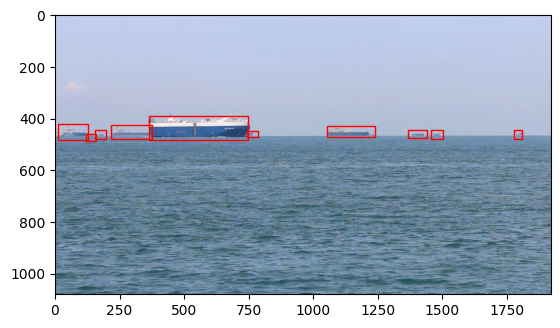

In [33]:
# draw bounding boxes for the image
im = np.array(Image.open(VIDEO_FRAMES_PATH_ONSHORE + video_name + "_frame" + frame +".jpg"), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# for every object in frame crate a rectangle patch
for entry in relevant_objects:
    data = entry.split(',')

    # Create a Rectangle patch
    rect = patches.Rectangle((float(data[1]),float(data[2])),float(data[3]),float(data[4]),linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [34]:
data[2]

'441.80841121495314'

# DATA STATISTICS (for all frames)

Here I will calculate some basic statistics for the objects and the dataset. Histogram of the height and width of the objects as well as in comparison to the total image size and the total area of the objects in comparison to the full image area.

In [39]:
# get images to play with
images_files_onshore = [join(VIDEO_FRAMES_PATH_ONSHORE, f) for f in listdir(VIDEO_FRAMES_PATH_ONSHORE) if isfile(join(VIDEO_FRAMES_PATH_ONSHORE, f))]
images_files_onboard = [join(VIDEO_FRAMES_PATH_ONBOARD, f) for f in listdir(VIDEO_FRAMES_PATH_ONBOARD) if isfile(join(VIDEO_FRAMES_PATH_ONBOARD, f))]
images_files_nir = [join(VIDEO_FRAMES_PATH_NIR, f) for f in listdir(VIDEO_FRAMES_PATH_NIR) if isfile(join(VIDEO_FRAMES_PATH_NIR, f))]


This is a working solution but it is too slow. Please use the next cell for faster computations. If you still need to load each image (for any reason) you can refer to the code in this cell.

In [40]:
# opening each image is TOO SLOW. Since the camera is the same the dimensions are known
# next cell has a faster solution with numpy

# for each image iterate over the bounding boxes of each object and calculate
# the total area, width and height in comparison to the image size
# here I play for 1 image only

height_rations_onshore = []
width_ratios_onshore = []
area_ratios_onshore = []

for image_path in images_files_onshore:

    im = np.array(Image.open(image_path), dtype=np.uint8)

    image_height, image_width, channels = im.shape
    image_initial = image_path.split('/')[-1].replace('.jpg', '')

    # gather relevant objects
    relevant_objects = [i for i in objects_onshore if i.startswith(image_initial)]
    # calculate the required statistics for every object bounding box
    for obj in relevant_objects:
        data = obj.split(',')
        bb_width = float(data[3])
        bb_height = float(data[4])
        width_ratios_onshore.append(bb_width / image_width)
        height_rations_onshore.append(bb_height / image_height)
        area_ratios_onshore.append((bb_width * bb_height) / (image_height * image_width))
        
for image_path in images_files_onboard:

    im = np.array(Image.open(image_path), dtype=np.uint8)

    image_height, image_width, channels = im.shape
    image_initial = image_path.split('/')[-1].replace('.jpg', '')

    # gather relevant objects
    relevant_objects = [i for i in objects_onboard if i.startswith(image_initial)]
    # calculate the required statistics for every object bounding box
    for obj in relevant_objects:
        data = obj.split(',')
        bb_width = float(data[3])
        bb_height = float(data[4])
        width_ratios_onshore.append(bb_width / image_width)
        height_rations_onshore.append(bb_height / image_height)
        area_ratios_onshore.append((bb_width * bb_height) / (image_height * image_width))


In [41]:
# the above solution is too slow
# here we will play with numpy

# the dimensions of the images are predefined to 1920*1080
image_height = 1080
image_width = 1920

# the number of objects is known and saved in "frames" list
number_of_objects_onshore = len(objects_onshore) # 154649
number_of_objects_onboard = len(objects_onboard) # 3349
number_of_objects_nir = len(objects_nir) # 83174

obj_height_onshore = np.zeros([number_of_objects_onshore])
obj_width_onshore = np.zeros([number_of_objects_onshore])
obj_area_onshore = np.zeros([number_of_objects_onshore])

obj_height_onboard = np.zeros([number_of_objects_onboard])
obj_width_onboard = np.zeros([number_of_objects_onboard])
obj_area_onboard = np.zeros([number_of_objects_onboard])

obj_height_nir = np.zeros([number_of_objects_nir])
obj_width_nir = np.zeros([number_of_objects_nir])
obj_area_nir = np.zeros([number_of_objects_nir])

In [42]:
for i, obj in enumerate(objects_onshore):
    data = obj.split(',')
    obj_width_onshore[i] = float(data[3])
    obj_height_onshore[i] = float(data[4])
    
obj_area_onshore = obj_width_onshore * obj_height_onshore

for i, obj in enumerate(objects_onboard):
    data = obj.split(',')
    obj_width_onboard[i] = float(data[3])
    obj_height_onboard[i] = float(data[4])
    
obj_area_onboard = obj_width_onboard * obj_height_onboard

for i, obj in enumerate(objects_nir):
    data = obj.split(',')
    obj_width_nir[i] = float(data[3])
    obj_height_nir[i] = float(data[4])
    
obj_area_nir = obj_width_nir * obj_height_nir

In [43]:
# scale them based on the image size
obj_width_ratio_onshore = obj_width_onshore.copy() / image_width
obj_height_ratio_onshore = obj_height_onshore.copy() / image_height
obj_area_ratio_onshore = obj_area_onshore.copy() / (image_height * image_width)

obj_width_ratio_onboard = obj_width_onboard.copy() / image_width
obj_height_ratio_onboard = obj_height_onboard.copy() / image_height
obj_area_ratio_onboard = obj_area_onboard.copy() / (image_height * image_width)

obj_width_ratio_nir = obj_width_nir.copy() / image_width
obj_height_ratio_nir = obj_height_nir.copy() / image_height
obj_area_ratio_nir = obj_area_nir.copy() / (image_height * image_width)

# Plot the histograms (OBSOLETE)

this is code for plotting the histograms but it is not required. It is included in the other notebooks for data statistics. These cells are left here for legacy purposes.

In [47]:
# folder to save the histograms
SAVE_FOLDER = './figures'

folder_names = [TRAIN_PATH, TEST_PATH, SAVE_FOLDER]

# first create the folders if they don't exist
for folder_name in folder_names:
    if not (os.path.isdir(folder_name)):
        os.mkdir(folder_name)

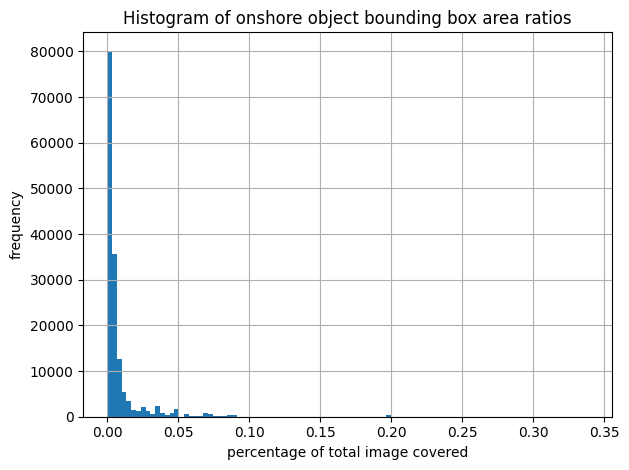

In [48]:
#plt.hist(obj_area_ratio, bins='auto')  # arguments are passed to np.histogram
plt.hist(obj_area_ratio_onshore, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of onshore object bounding box area ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of total image covered")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_area_onshore.jpg"), dpi=300)
plt.show()

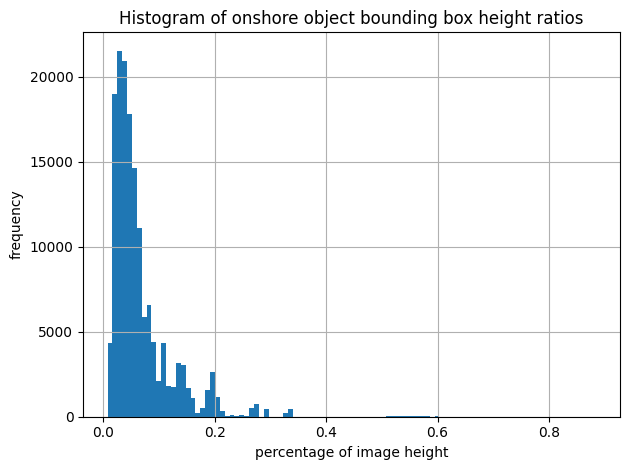

In [50]:
plt.hist(obj_height_ratio_onshore, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of onshore object bounding box height ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of image height")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_height_onshore.jpg"), dpi=300)
plt.show()

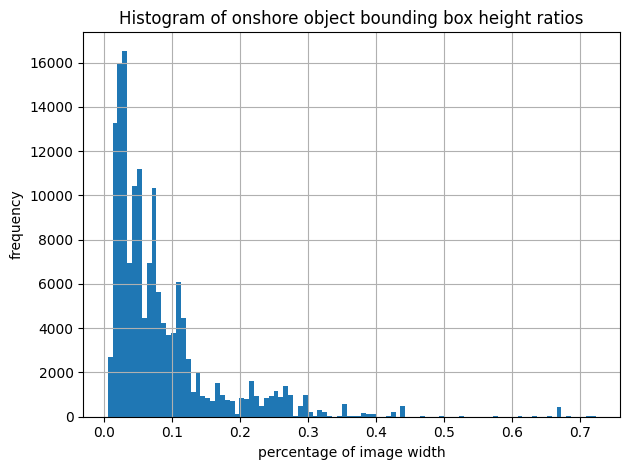

In [51]:
plt.hist(obj_width_ratio_onshore, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of onshore object bounding box height ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of image width")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_width_onshore.jpg"), dpi=300)
plt.show()

Do the histograms for the onboard objects

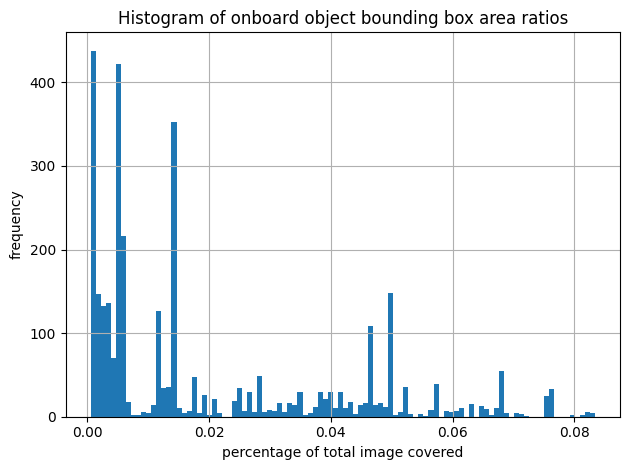

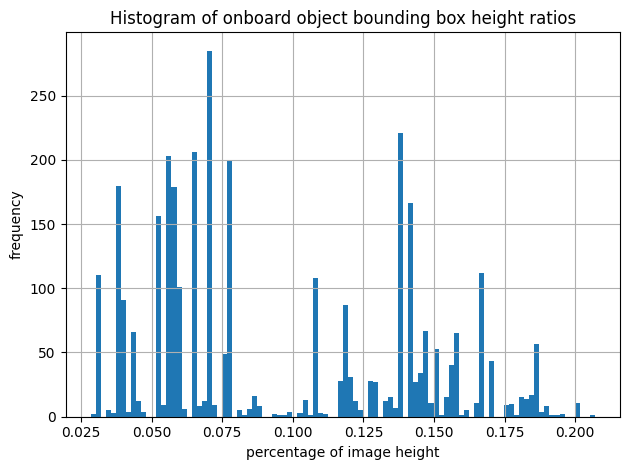

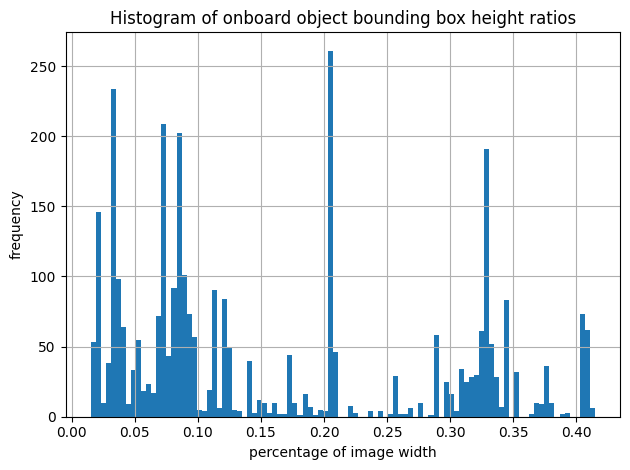

In [52]:
plt.hist(obj_area_ratio_onboard, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of onboard object bounding box area ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of total image covered")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_area_onboard.jpg"), dpi=300)
plt.show()

plt.hist(obj_height_ratio_onboard, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of onboard object bounding box height ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of image height")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_height_onboard.jpg"), dpi=300)
plt.show()

plt.hist(obj_width_ratio_onboard, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of onboard object bounding box height ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of image width")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_width_onboard.jpg"), dpi=300)
plt.show()

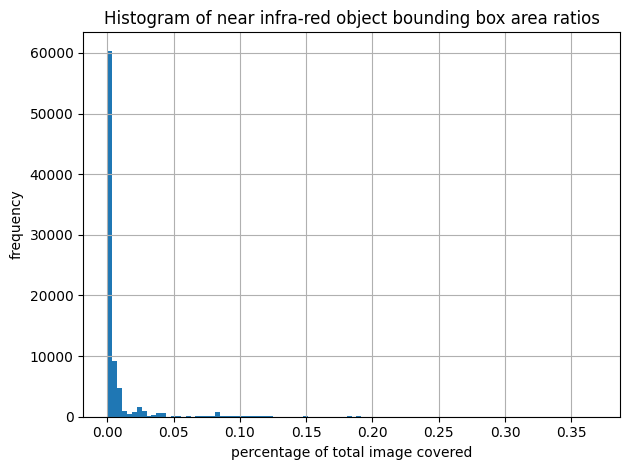

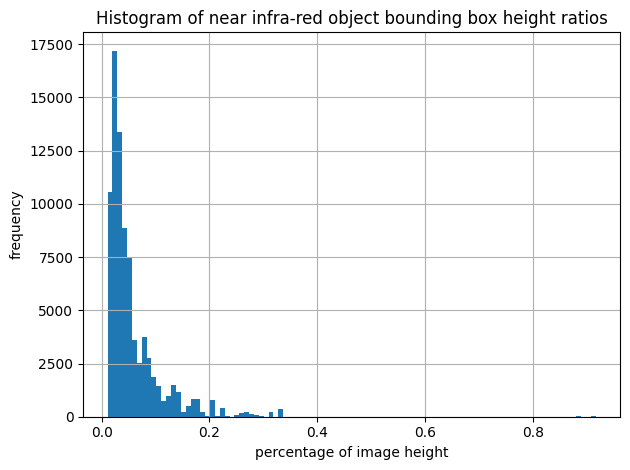

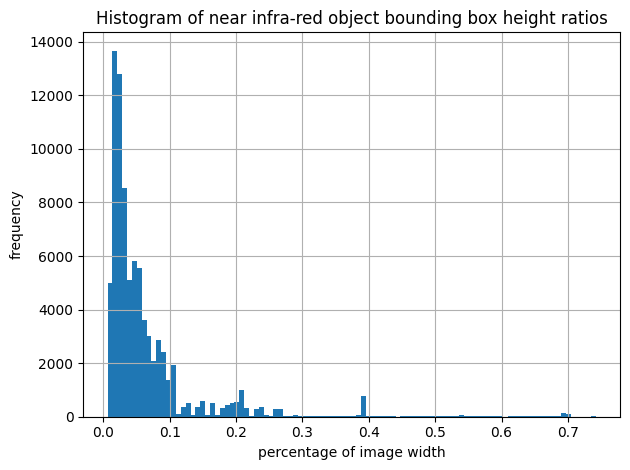

In [53]:
plt.hist(obj_area_ratio_nir, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of near infra-red object bounding box area ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of total image covered")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_area_nir.jpg"), dpi=300)
plt.show()

plt.hist(obj_height_ratio_nir, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of near infra-red object bounding box height ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of image height")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_height_nir.jpg"), dpi=300)
plt.show()

plt.hist(obj_width_ratio_nir, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of near infra-red object bounding box height ratios")
plt.ylabel("frequency")
plt.xlabel("percentage of image width")
plt.grid()

plt.tight_layout()

plt.savefig(os.path.join(SAVE_FOLDER, "histogram_width_nir.jpg"), dpi=300)
plt.show()